# **Project #4 - Food Recognition**
### Deep Learning course - A.Y. 2020-2021
Students:

- Giuseppe	Murro	(0000997317 $-$ giuseppe.murro@studio.unibo.it)
- Salvatore	Pisciotta	(0000985203 $-$ salvatore.pisciotta2@studio.unibo.it)

Install segmentation_models library

In [ ]:
!pip install segmentation_models

Clone the repo in order to access to the dataset

In [1]:
!git clone https://github.com/gmurro/FoodRecognition.git
%cd /content/FoodRecognition/src

Cloning into 'FoodRecognition'...
remote: Enumerating objects: 77705, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 77705 (delta 16), reused 45 (delta 13), pack-reused 77657
Receiving objects: 100% (77705/77705), 1.33 GiB | 33.57 MiB/s, done.
Resolving deltas: 100% (23608/23608), done.
Checking out files: 100% (55363/55363), done.
/content/FoodRecognition/src


Import useful libraries

In [1]:
import numpy as np
import random
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from utils import segmentation_utils

Define the categories of food on which we want train the segmentation model

In [2]:
cat_names = ['water'
             , 'bread-white'
             , 'salad-leaf-salad-green'
             , 'tomato'
             , 'butter'
             , 'carrot'
             , 'coffee-with-caffeine'
             , 'rice'
             , 'egg'
             , 'mixed-vegetables'
             , 'wine-red'
             , 'apple'
             , 'jam'
             , 'potatoes-steamed'
             , 'banana'
             , 'cheese' ]
             
batch_size = 32
img_size = (128,128)
num_classes = len(cat_names) + 1

Define the class `DataGenerator`, which will be used for real-time data feeding to our Keras model.
We make the latter inherit the properties of `keras.utils.Sequence` so that we can leverage nice functionalities such as *multiprocessing*.

In [3]:
class DataGenerator(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, coco, batch_size, img_size, img_ids, img_paths, cat_to_label, aug_args=None, shuffle=True):
        self.coco = coco
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_paths = img_paths
        self.img_ids = img_ids
        self.cat_to_label = cat_to_label
        self.aug_args = aug_args
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """ Number of batches per epoch """
        return len(self.img_ids) // self.batch_size

    def __getitem__(self, idx):
        """ Generate one batch of data """

        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        # n of categories
        n_cat = len(self.cat_to_label)

        # Find list of img paths and image ids to read in the batch
        batch_img_paths = [self.img_paths[i] for i in indexes]
        batch_img_ids = [self.img_ids[i] for i in indexes]

        # load imgs
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype=np.float32)
        for j, path in enumerate(batch_img_paths):
            img = img_to_array(load_img(path, target_size=self.img_size))
            x[j] = img

        # load masks
        y = np.zeros((self.batch_size,) + self.img_size + (n_cat,), dtype=np.float32)
        for j, img_id in enumerate(batch_img_ids):
            mask = segmentation_utils.load_mask(self.coco, img_id, self.cat_to_label)

            # scale down mask
            mask_scaled = np.zeros(self.img_size+ (n_cat,), dtype=np.uint8)
            for i in range(n_cat):
                mask_scaled[:,:,i] = Image.fromarray(mask[:,:,i]).resize(self.img_size, Image.NEAREST)

            y[j] = np.array(mask_scaled, dtype=np.float32)
            
        if self.aug_args is not None:
            x, y = segmentation_utils.augment(x, y, self.aug_args)
            
            #
            
        return x, y

    def on_epoch_end(self):
        """ Method called at the end of every epoch that updates indexes """
        self.indexes = np.arange(len(self.img_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

Test if the DataGenerator works well

In [4]:
# @title Test of the DataGenerator
path_dir = "../data/val/"   # @param {type: "string"}

# load images and other info from annotations
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_label = segmentation_utils.load_imgs(coco, cat_names)

img_paths = [os.path.join(path_dir+"images/", file_name) for file_name in img_names]

# parameters for the augmetation
aug_args = dict(
                  rotation_range=5              # @param {type:"slider", min:0, max:10, step:1}
                , width_shift_range=0.01        # @param {type:"slider", min:0, max:0.1, step:0.01}
                , height_shift_range=0.01       # @param {type:"slider", min:0, max:0.1, step:0.01}
                , shear_range=0.01              # @param {type:"slider", min:0, max:0.1, step:0.01}
                , zoom_range=[0.9, 1]           
                , horizontal_flip=True          # @param {type:"boolean"} 
                , vertical_flip=True            # @param {type:"boolean"} 
                , fill_mode='nearest'          #@param ["constant", "nearest", "reflect", "wrap"] {type:"raw"}
                , data_format='channels_last')

# create the generator with augmemtation
data_gen = DataGenerator(coco, batch_size, img_size, img_ids, img_paths, cat_to_label, aug_args)

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


In [5]:
# read a batch from the generator
data= data_gen.__getitem__(0)
x = data[0]
y  = data[1]

print("x shape:",x.shape)
print("y shape:",y.shape)

x shape: (32, 128, 128, 3)
y shape: (32, 128, 128, 17)



Image 4


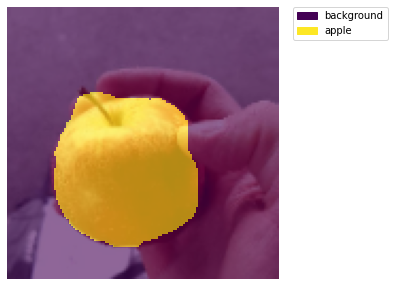


Image 5


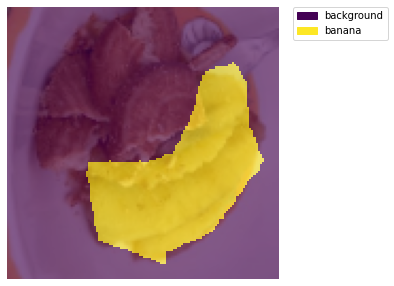


Image 6


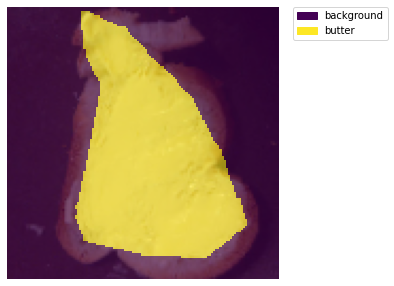

In [7]:
# read 3 random image from the batches
n = 3

idx = np.random.randint(0, batch_size-1-n)

for i in range(idx,idx+n):
    print("\nImage {}".format(i))
    segmentation_utils.show_mask(x[i,:,:,:]/255, y[i,:,:,:], cat_names)

Test load data without DataGenerator

In [7]:
# LOAD ALL DATA
x, y = segmentation_utils.load_data(coco, path_dir+"images/", img_size, cat_names)

Loading images:
657/661 [============================>.] - ETA: 0s
Loading masks:
660/661 [============================>.] - ETA: 0s


Image 98


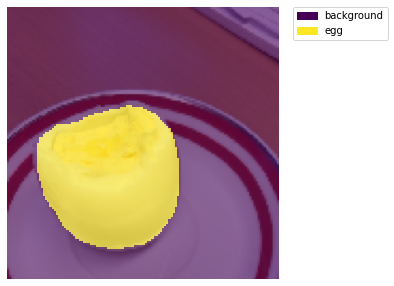

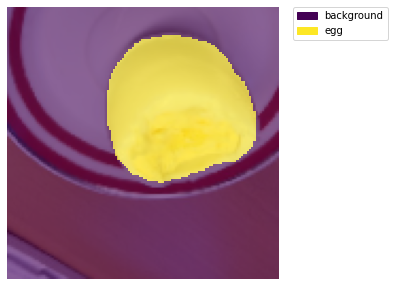


Image 99


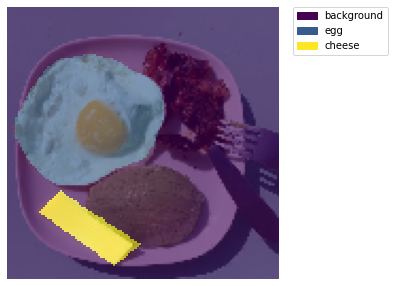

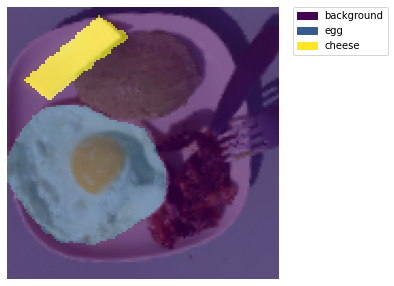


Image 100


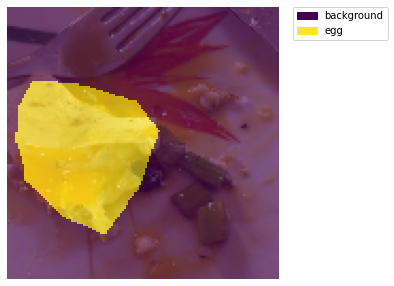

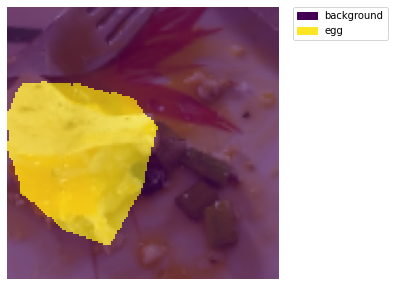

In [8]:
# show 3 random image and compare with augmentation
n = 3

idx = random.randint(0, len(x)-1-n)

for i in range(idx,idx+n):
    print("\nImage {}".format(i))

    # show image not augmented
    segmentation_utils.show_mask(x[i,:,:]/255, y[i,:,:,:], cat_names)

    # show the same image augmented
    x_p = x[i].reshape((1,)+x[i].shape)
    y_p = y[i].reshape((1,)+y[i].shape)
    x_aug, y_aug = segmentation_utils.augment(x_p, y_p, aug_args)
    segmentation_utils.show_mask(x_aug[0,:,:]/255, y_aug[0,:,:,:], cat_names)

My Custom U-Net

In [8]:
from tensorflow.keras import layers

def conv_block(input, num_filters, size=3, padding='same', initializer="he_normal"):
    x = layers.Conv2D(filters=num_filters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(filters=num_filters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def deconv_block(input, num_filters, skip_features, size=2, padding='same', strides=(2, 2)):
    x = layers.Conv2DTranspose(num_filters, kernel_size=(size, size), strides=strides, padding=padding)(input)
    x = layers.concatenate([x, skip_features], axis=3)
    x = conv_block(x, num_filters)
    return x

def unet(img_size, num_classes, num_filters=64):
    
    ''' Input layer '''
    input_layer = layers.Input(shape=img_size + (3,), name='image_input')
    # s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalization
    
    ''' Contractive path '''
    ### Layer 1
    conv1 = conv_block(input_layer, num_filters=num_filters)
    conv1_out = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    ### Layer 2
    conv2 = conv_block(conv1_out, num_filters=num_filters*2)
    conv2_out = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    ### Layer 3
    conv3 = conv_block(conv2_out, num_filters=num_filters*4)
    conv3_out = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    ### Layer 4
    conv4 = conv_block(conv3_out, num_filters=num_filters*8)
    conv4_out = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = layers.Dropout(0.5)(conv4_out)
    
    ### Layer 5
    conv5 = conv_block(conv4_out, num_filters=num_filters*16)
    conv5 = layers.Dropout(0.5)(conv5)
    
    ''' Expansive path '''
    ### Layer 6
    deconv6 = deconv_block(conv5, num_filters=num_filters*8, skip_features=conv4)
    deconv6 = layers.Dropout(0.5)(deconv6)
    
    ### Layer 7
    deconv7 = deconv_block(deconv6, num_filters=num_filters*4, skip_features=conv3,)
    
    ### Layer 8
    deconv8 = deconv_block(deconv7, num_filters=num_filters*2, skip_features=conv2)
    
    ### Layer 9
    deconv9 = deconv_block(deconv8, num_filters=num_filters, skip_features=conv1)
    
    # output: add a per-pixel classification layer
    output_layer = layers.Conv2D(filters=num_classes, kernel_size=(1, 1), activation="softmax", padding="same")(deconv9)
    
    # Define the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='u-net')
    return model

# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = unet(img_size, num_classes, num_filters=16)
model.summary()

Model: "u-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Prepare U-Net Xception-style model like in this [guide](https://keras.io/examples/vision/oxford_pets_image_segmentation/)

In [25]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

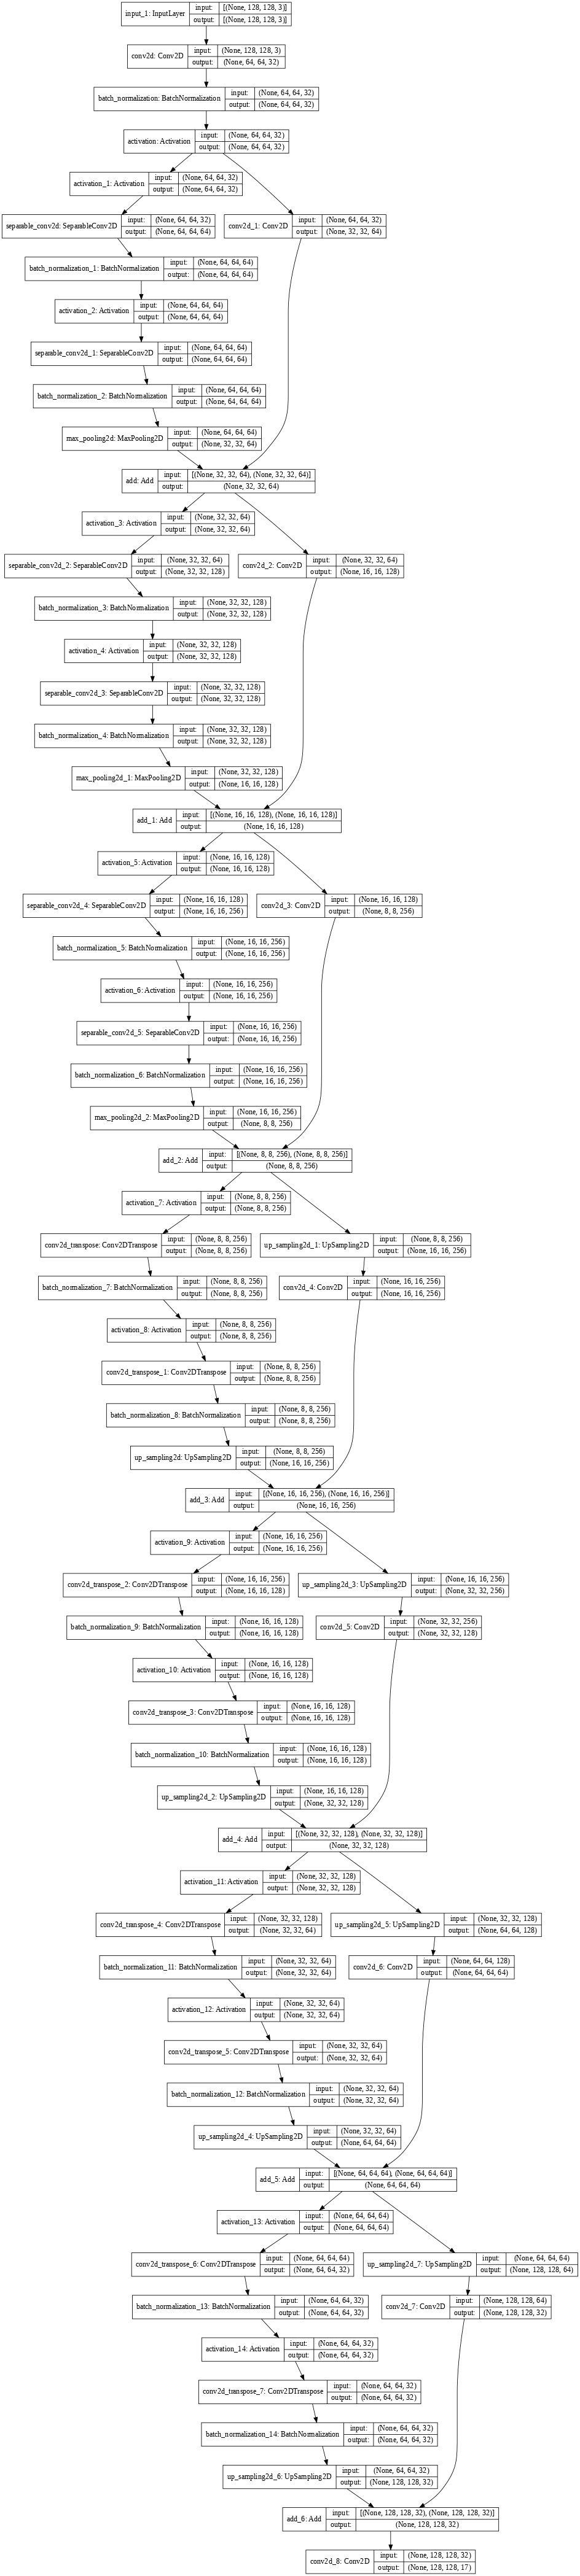

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

Instantiate data Generators for training and validation set

In [9]:
# @title DataGenerator fro training set
path_dir = "../data/train/"   # @param {type: "string"}

# load images and other info from annotations
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_label = segmentation_utils.load_imgs(coco, cat_names)

img_paths = [os.path.join(path_dir+"images/", file_name) for file_name in img_names]

# parameters for the augmetation
aug_args = dict(
                  rotation_range=5              # @param {type:"slider", min:0, max:10, step:1}
                , width_shift_range=0.01        # @param {type:"slider", min:0, max:0.1, step:0.01}
                , height_shift_range=0.01       # @param {type:"slider", min:0, max:0.1, step:0.01}
                , brightness_range=(0.8, 1.2)  
                , shear_range=0.01              # @param {type:"slider", min:0, max:0.1, step:0.01}
                , zoom_range=[0.7, 1]           
                , horizontal_flip=True          # @param {type:"boolean"} 
                , vertical_flip=True            # @param {type:"boolean"} 
                , fill_mode='constant'          #@param ["constant", "nearest", "reflect", "wrap"] {type:"raw"}
                , data_format='channels_last')

# create the generator
train_gen = DataGenerator(coco, batch_size, img_size, img_ids, img_paths,  cat_to_label, aug_args)

loading annotations into memory...
Done (t=4.13s)
creating index...
index created!


In [10]:
# @title DataGenerator fro training set
path_dir = "../data/val/"   # @param {type: "string"}

# load images and other info from annotations
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_label = segmentation_utils.load_imgs(coco, cat_names)

img_paths = [os.path.join(path_dir+"images/", file_name) for file_name in img_names]

# create the generator
val_gen = DataGenerator(coco, batch_size, img_size, img_ids, img_paths, cat_to_label)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


In [26]:
%env SM_FRAMEWORK = tf.keras
import segmentation_models as sm

#loss = sm.losses.DiceLoss(per_image=True, class_weights=class_weights) + sm.losses.BinaryFocalLoss() + sm.losses.JaccardLoss(per_image=True, class_weights=class_weights)
#TODO ADD CLASS WEIGHTS

loss = sm.losses.categorical_focal_loss

threshold = 0.5
metrics = [sm.metrics.IOUScore(threshold=threshold, per_image=True)
           , sm.metrics.Precision(threshold=threshold, per_image=True)
           , sm.metrics.Recall(threshold=threshold, per_image=True)
           , sm.metrics.FScore(threshold=threshold, per_image=True)]

env: SM_FRAMEWORK=tf.keras


In [13]:
# Configure the model for training.
# We use  categorical_crossentropy
model.compile(optimizer="adam"
              , loss=loss
              , metrics=metrics)

In [33]:
import datetime
cp_file_name = "model/food_segmentation_focal_60_epochs_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +".h5"

callbacks = [
    #Model checkpoint save weights ad other informations
    tf.keras.callbacks.ModelCheckpoint(cp_file_name, save_best_only=True)
    , tf.keras.callbacks.TensorBoard(log_dir="model/logs/tensorboard_logs_60_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks, workers=6)

Epoch 1/30
402/402 [==============================] - 998s 2s/step - loss: 0.0083 - iou_score: 0.8989 - precision: 0.9781 - recall: 0.9118 - f1-score: 0.9088 - val_loss: 0.0061 - val_iou_score: 0.9103 - val_precision: 0.9909 - val_recall: 0.9172 - val_f1-score: 0.9184
Epoch 2/30
402/402 [==============================] - 974s 2s/step - loss: 0.0082 - iou_score: 0.8993 - precision: 0.9773 - recall: 0.9123 - f1-score: 0.9092 - val_loss: 0.0064 - val_iou_score: 0.9110 - val_precision: 0.9886 - val_recall: 0.9195 - val_f1-score: 0.9194
Epoch 3/30
402/402 [==============================] - 923s 2s/step - loss: 0.0081 - iou_score: 0.8999 - precision: 0.9777 - recall: 0.9126 - f1-score: 0.9098 - val_loss: 0.0061 - val_iou_score: 0.9131 - val_precision: 0.9875 - val_recall: 0.9227 - val_f1-score: 0.9209
Epoch 4/30
402/402 [==============================] - 942s 2s/step - loss: 0.0081 - iou_score: 0.8998 - precision: 0.9778 - recall: 0.9126 - f1-score: 0.9098 - val_loss: 0.0059 - val_iou_score:

In [25]:
import matplotlib.pyplot as plt
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

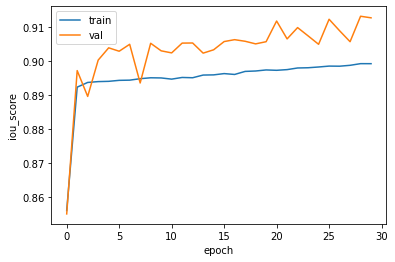

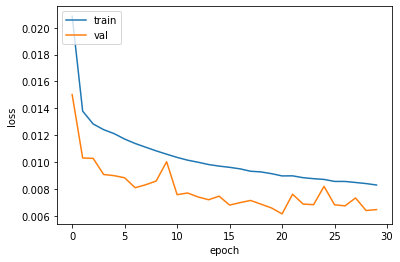

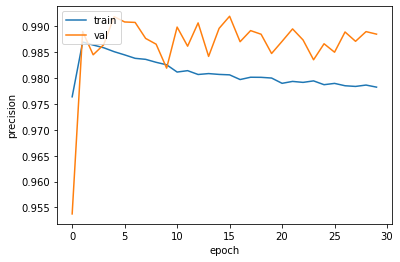

In [26]:
# fit from 0 to 30
plot_history(history,['iou_score','val_iou_score'])
plot_history(history,['loss','val_loss'])
plot_history(history,['precision','val_precision'])

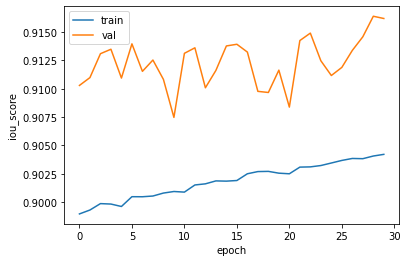

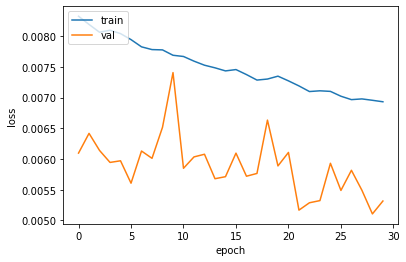

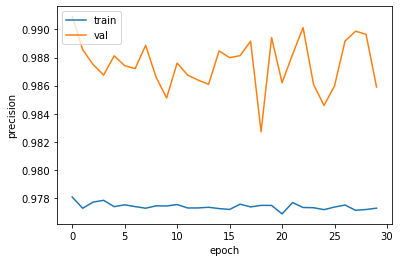

In [34]:
# fit from 30 to 60
plot_history(history,['iou_score','val_iou_score'])
plot_history(history,['loss','val_loss'])
plot_history(history,['precision','val_precision'])

In [12]:
# if you have pretrained weights, load them here
model.load_weights('model/food_segmentation_focal_60_epochs_20210601-003937.h5')

In [13]:
# LOAD VAL DATA
x, y = segmentation_utils.load_data(coco, "../data/val/images/", img_size, cat_names)

Loading images:
551/554 [============================>.] - ETA: 0s
Loading masks:
553/554 [============================>.] - ETA: 0s

In [14]:
val_preds = model.predict(x)

In [37]:
from keras import backend as K

smooth = 1e-5

def dice_coef(y_true, y_pred):
    y_true = y_true.astype('float32')
    y_pred = y_pred.astype('float32')
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [33]:
def display_mask(i, size=img_size):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    img = img.resize(size)
    display(img)
    print(img.size)

def get_pred_mask(pred):
   mask = np.argmax(pred, axis=-1)
   return mask
def binarize(pred, thresold):
   return np.where(pred > thresold, 1., 0.)

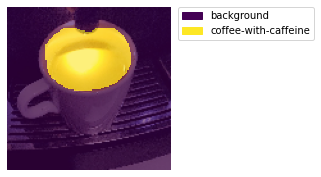

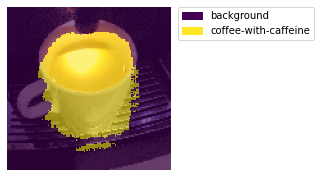

tf.Tensor(0.15308744, shape=(), dtype=float32)
tf.Tensor(0.15308744, shape=(), dtype=float32)
--------------------------------------------------------------


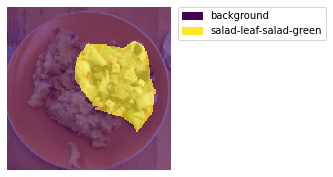

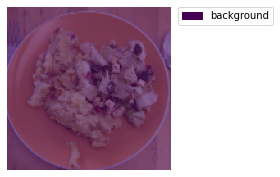

tf.Tensor(0.18579102, shape=(), dtype=float32)
tf.Tensor(0.18579102, shape=(), dtype=float32)
--------------------------------------------------------------


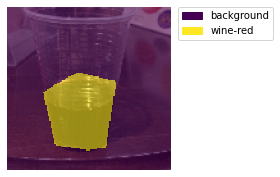

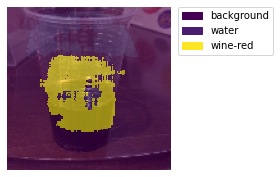

tf.Tensor(0.17320114, shape=(), dtype=float32)
tf.Tensor(0.17320114, shape=(), dtype=float32)
--------------------------------------------------------------


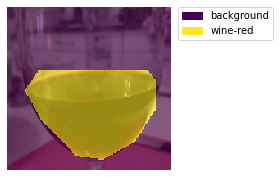

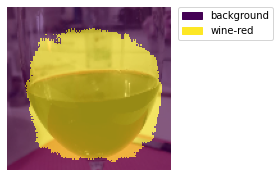

tf.Tensor(0.20295995, shape=(), dtype=float32)
tf.Tensor(0.20295995, shape=(), dtype=float32)
--------------------------------------------------------------


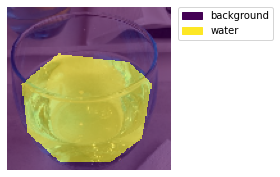

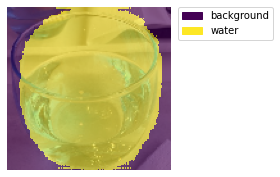

tf.Tensor(0.24413884, shape=(), dtype=float32)
tf.Tensor(0.24413884, shape=(), dtype=float32)
--------------------------------------------------------------


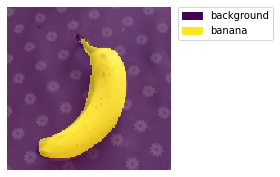

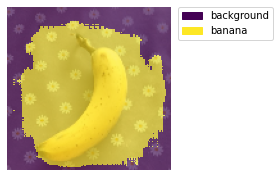

tf.Tensor(0.24276108, shape=(), dtype=float32)
tf.Tensor(0.24276108, shape=(), dtype=float32)
--------------------------------------------------------------


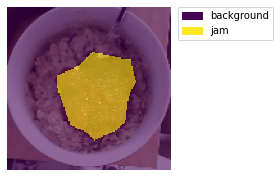

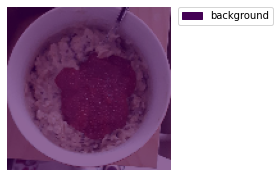

tf.Tensor(0.16317004, shape=(), dtype=float32)
tf.Tensor(0.16317004, shape=(), dtype=float32)
--------------------------------------------------------------


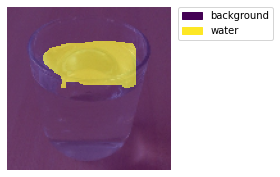

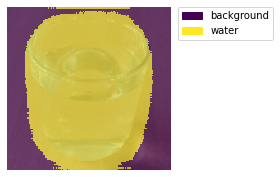

tf.Tensor(0.26772928, shape=(), dtype=float32)
tf.Tensor(0.26772928, shape=(), dtype=float32)
--------------------------------------------------------------


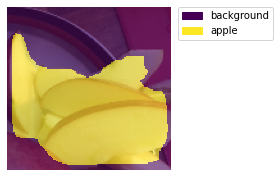

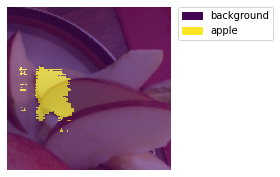

tf.Tensor(0.47709823, shape=(), dtype=float32)
tf.Tensor(0.47709823, shape=(), dtype=float32)
--------------------------------------------------------------


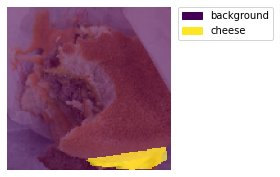

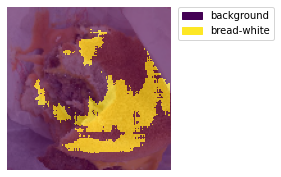

tf.Tensor(0.12702209, shape=(), dtype=float32)
tf.Tensor(0.12702209, shape=(), dtype=float32)
--------------------------------------------------------------


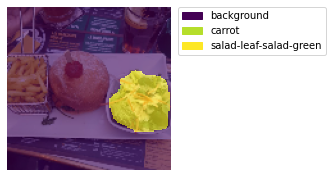

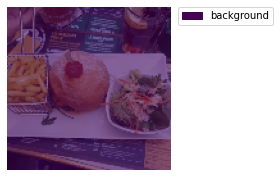

tf.Tensor(0.12508976, shape=(), dtype=float32)
tf.Tensor(0.12508976, shape=(), dtype=float32)
--------------------------------------------------------------


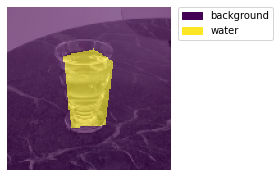

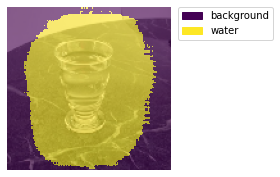

tf.Tensor(0.23544645, shape=(), dtype=float32)
tf.Tensor(0.23544645, shape=(), dtype=float32)
--------------------------------------------------------------


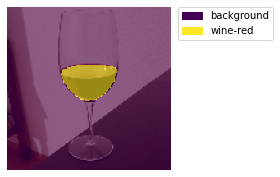

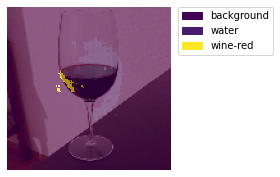

tf.Tensor(0.083527565, shape=(), dtype=float32)
tf.Tensor(0.083527565, shape=(), dtype=float32)
--------------------------------------------------------------


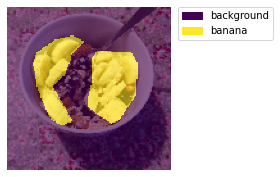

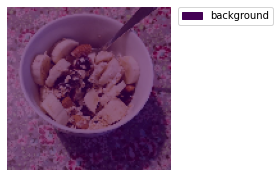

tf.Tensor(0.18890381, shape=(), dtype=float32)
tf.Tensor(0.18890381, shape=(), dtype=float32)
--------------------------------------------------------------


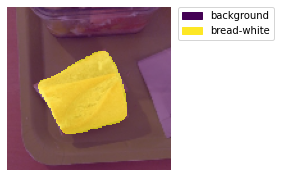

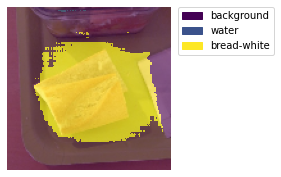

tf.Tensor(0.15777296, shape=(), dtype=float32)
tf.Tensor(0.15777296, shape=(), dtype=float32)
--------------------------------------------------------------


In [40]:
# Display 5 random predictions
n = 15
np.random.seed(1)
idx = np.random.choice(range(len(val_preds)), n)

imgs = [x[i]/255 for i in idx]
masks = [y[i][:,:,0] for i in idx]
predicions = [get_pred_mask(val_preds[i]) for i in idx]

for i in idx:
    segmentation_utils.show_mask(x[i]/255, y[i,:,:,:], cat_names, figsize=(3,3))
    segmentation_utils.show_mask(x[i]/255, binarize(val_preds[i], 0.3), cat_names, figsize=(3,3))
    print(dice_coef_loss(y[i,:,:,:], binarize(val_preds[i,:,:,:], 0.3)))
    print(sm.losses.DiceLoss().__call__(y[i,:,:,:].astype('float32'), binarize(val_preds[i,:,:,:], 0.3).astype('float32')))
    print("--------------------------------------------------------------")

In [52]:
%load_ext tensorboard
%tensorboard --logdir model/logs/tensorboard_logs_20210531-160755

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9020), started 0:03:15 ago. (Use '!kill 9020' to kill it.)

In [53]:
!taskkill /PID 9020 /F

OPERAZIONE RIUSCITA: il processo con il PID 9020 Š stato terminato.


In [54]:
%reload_ext tensorboard
%tensorboard --logdir model/logs/tensorboard_logs_60_20210601-003937

Reusing TensorBoard on port 6006 (pid 18460), started 0:03:04 ago. (Use '!kill 18460' to kill it.)